## Basic Import

In [34]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import pandas as pd
import json
import time
import math
import heapq
import matplotlib.pyplot as plt

In [76]:
pip show torch

Name: torch
Version: 2.3.0a0+6ddf5cf85e.nv24.4
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, fsspec, jinja2, networkx, sympy, typing-extensions
Required-by: flash-attn, lightning-thunder, torch-tensorrt, torchdata, torchtext, torchvision, transformer-engine
Note: you may need to restart the kernel to use updated packages.


## class for 3 models

In [37]:
class GMF(nn.Module):
    def __init__(self,num_users,num_items,embedding_dim):
        super(GMF,self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        self.output_layer = nn.Linear(embedding_dim, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self,user_id,item_id):
        user_emb = self.user_embedding(user_id)
        item_emb = self.item_embedding(item_id)
        elementwise_product = torch.mul(user_emb, item_emb)
        prediction = self.output_layer(elementwise_product)
        rating = self.sigmoid(prediction)
        return rating

In [38]:
class MLP(nn.Module):
    def __init__(self,num_users,num_items,layers):
        super(MLP,self).__init__()
        self.num_layers = len(layers)
        self.user_embedding = nn.Embedding(num_users, layers[0] // 2)
        self.item_embedding = nn.Embedding(num_items, layers[0] // 2)
        self.mlp_layers = nn.ModuleList()
        for i in range(1, self.num_layers):
            self.mlp_layers.append(nn.Linear(layers[i - 1], layers[i]))
        self.output_layer = nn.Linear(layers[-1], 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    def forward(self, user_id, item_id):
        user_emb = self.user_embedding(user_id)
        item_emb = self.item_embedding(item_id)
        x = torch.cat([user_emb, item_emb], dim=1)
        for i, layer in enumerate(self.mlp_layers):
            x = self.relu(layer(x))
        prediction = self.output_layer(x)
        prediction = self.sigmoid(prediction)
        return prediction

In [39]:
class NeuMF(nn.Module):
    def __init__(self,num_users,num_items,layers,mf_dim):
        super(NeuMF,self).__init__()
        self.num_layers = len(layers)
        self.mf_user_embedding = nn.Embedding(num_users, mf_dim)
        self.mf_item_embedding = nn.Embedding(num_items, mf_dim)
        self.mlp_user_embedding = nn.Embedding(num_users, layers[0] // 2)
        self.mlp_item_embedding = nn.Embedding(num_items, layers[0] // 2)
        self.mlp_layers = nn.ModuleList()
        for i in range(1, self.num_layers):
            self.mlp_layers.append(nn.Linear(layers[i - 1], layers[i]))
        self.output_layer = nn.Linear(mf_dim + layers[-1], 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,user_id, item_id):
        mf_user_emb = self.mf_user_embedding(user_id)
        mf_item_emb = self.mf_item_embedding(item_id)
        elementwise_product = torch.mul(mf_user_emb, mf_item_emb)
        mlp_user_emb = self.mlp_user_embedding(user_id)
        mlp_item_emb = self.mlp_item_embedding(item_id)
        mlp_vector = torch.cat([mlp_user_emb, mlp_item_emb], dim=1)
        for i, layer in enumerate(self.mlp_layers):
            mlp_vector = self.relu(layer(mlp_vector))
        predict_vector = torch.cat([elementwise_product, mlp_vector], dim=1)
        prediction = self.output_layer(predict_vector)
        prediction = self.sigmoid(prediction)
        return prediction

## class for dataset

In [40]:
class UserItemDataset(Dataset):
    def __init__(self, num_negatives):
        self.num_negatives=num_negatives
        with open("data/output.json", "r") as infile:
            self.data = json.load(infile)
        
        self.train_data=self.load_data()
        
    def load_data(self):
        train_data = []
        with open("data/ml-1m.train.rating", "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                user, item = int(arr[0]), int(arr[1])
                train_data.append((user,item,1.0))
                list=self.data[str(user)]
                for t in range(self.num_negatives):
                    j=np.random.randint(len(list))
                    train_data.append((user,list[j],0))
                line = f.readline()
        return train_data
    
    def __len__(self):
        return len(self.train_data)
    
    def __getitem__(self, index):
        return self.train_data[index][0], self.train_data[index][1], self.train_data[index][2]

## define the training and evaluating procedure

In [41]:
def evaluate(model, testRatings, testNegatives, K, device):
    model.eval()
    hits, ndcgs = [], []

    with torch.no_grad():
        for idx in range(len(testRatings)):
            rating = testRatings[idx]
            items = testNegatives[idx] + [rating[1]] 
            u = rating[0]
            gtItem = rating[1]

            users = torch.full((len(items),), u, dtype=torch.long).to(device)
            movies = torch.tensor(items, dtype=torch.long).to(device)

            predictions = model(users, movies)
            
            _, indices = torch.topk(predictions, K, dim=0)
            ranklist = [items[index] for index in indices]  

            hr = getHitRatio(ranklist, gtItem)
            ndcg = getNDCG(ranklist, gtItem)
            hits.append(hr)
            ndcgs.append(ndcg)

    return np.mean(hits), np.mean(ndcgs)

def getHitRatio(ranklist, gtItem):
    if gtItem in ranklist:
        return 1
    return 0

def getNDCG(ranklist, gtItem):
    for i, item in enumerate(ranklist):
        if item == gtItem:
            return math.log(2) / math.log(i + 2)
    return 0

In [42]:
def train(model,criterion,optimizer,num_epochs,dataloader,testRatings,testNegatives,K,device):
    train_losses = []  
    hrs = []  
    ndcgs = []
    
    for epoch in range(num_epochs):
        model.train()
        start=time.time()
        epoch_loss = 0
        
        print(f"epoch {epoch+1}/{num_epochs}")
        for batch_users, batch_items, batch_ratings in dataloader:
            
            batch_users = batch_users.to(device)
            batch_items = batch_items.to(device)
            batch_ratings = batch_ratings.float().to(device)

            predictions = model(batch_users, batch_items)

            loss = criterion(predictions.view(-1), batch_ratings)
            epoch_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
         
        avg_epoch_loss = epoch_loss / len(dataloader)
        train_losses.append(avg_epoch_loss)
        hr,ndcg=evaluate(model,testRatings,testNegatives,K,device)
        hrs.append(hr)
        ndcgs.append(ndcg)
        end=time.time()
        
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_epoch_loss:.4f} - HR:{hr:.4f} - NDCG:{ndcg:.4f} - Time:{int(end-start)}s")
    
    return train_losses, hrs, ndcgs
        

## preparation work

In [35]:
# get the number of users and movies
ratings = pd.read_csv("mv-1m/ratings.dat", sep="::", engine="python", header=None, names=["userId", "movieId", "rating", "timestamp"])
num_users = ratings["userId"].nunique()
num_movies = ratings["movieId"].nunique()

In [36]:
# get the data for evaluating the model
testRatings = []
with open("data/ml-1m.test.rating", "r") as f:
    line = f.readline()
    while line != None and line != "":
        arr = line.split("\t")
        user, item = int(arr[0]), int(arr[1])
        testRatings.append([user, item])
        line = f.readline()
                
testNegatives = []
with open("data/ml-1m.test.negative", "r") as f:
    line = f.readline()
    while line != None and line != "":
        arr = line.split("\t")
        negatives = []
        for x in arr[1: ]:
            negatives.append(int(x))
        testNegatives.append(negatives)
        line = f.readline()

In [12]:
dataset = UserItemDataset(num_negatives=4)

In [13]:
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

In [19]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU is available")
else:
    device = torch.device('cpu')
    
criterion=nn.BCELoss()
num_epochs=50
K=10

GPU is available


## model training and evaluating

由于本次任务是复现论文结果而不是构造一个框架，并且为了方便调试和易于观测，这里才把每一个模型都分开进行训练。

In [ ]:
gmf=GMF(num_users,num_movies,embedding_dim=8).to(device)
optimizer_gmf = optim.Adam(gmf.parameters(), lr=0.001)
gmf_train_losses, gmf_hrs, gmf_ndcgs =train(gmf,criterion,optimizer_gmf,num_epochs,dataloader,testRatings,testNegatives,K,device)

In [ ]:
mlp_3=MLP(num_users,num_movies,[64,32,16,8]).to(device)
optimizer_mlp_3 = optim.Adam(mlp_3.parameters(), lr=0.001)
mlp_3_train_losses, mlp_3_hrs, mlp_3_ndcgs=train(mlp_3,criterion,optimizer_mlp_3,num_epochs,dataloader,testRatings,testNegatives,K,device)

In [ ]:
neumf=NeuMF(num_users,num_movies,[64,32,16,8],mf_dim=8).to(device)
optimizer_neumf=optim.Adam(neumf.parameters(),lr=0.001)
neumf_train_losses, neumf_hrs,neumf_ndcgs=train(neumf,criterion,optimizer_neumf,num_epochs,dataloader,testRatings,testNegatives,K,device)

In [ ]:
mlp_0=MLP(num_users,num_movies,[16]).to(device)
optimizer_mlp_0 = optim.Adam(mlp_0.parameters(), lr=0.001)
mlp_0_train_losses, mlp_0_hrs, mlp_0_ndcgs=train(mlp_0,criterion,optimizer_mlp_0,num_epochs,dataloader,testRatings,testNegatives,K,device)

In [ ]:
mlp_1=MLP(num_users,num_movies,[16,8]).to(device)
optimizer_mlp_1 = optim.Adam(mlp_1.parameters(), lr=0.001)
mlp_1_train_losses, mlp_1_hrs, mlp_1_ndcgs=train(mlp_1,criterion,optimizer_mlp_1,num_epochs,dataloader,testRatings,testNegatives,K,device)

In [ ]:
mlp_2=MLP(num_users,num_movies,[32,16,8]).to(device)
optimizer_mlp_2 = optim.Adam(mlp_2.parameters(), lr=0.001)
mlp_2_train_losses, mlp_2_hrs, mlp_2_ndcgs=train(mlp_2,criterion,optimizer_mlp_2,num_epochs,dataloader,testRatings,testNegatives,K,device)

In [ ]:
mlp_4=MLP(num_users,num_movies,[128,64,32,16,8]).to(device)
optimizer_mlp_4 = optim.Adam(mlp_4.parameters(), lr=0.001)
mlp_4_train_losses, mlp_4_hrs, mlp_4_ndcgs=train(mlp_4,criterion,optimizer_mlp_4,num_epochs,dataloader,testRatings,testNegatives,K,device)

## visualize the output

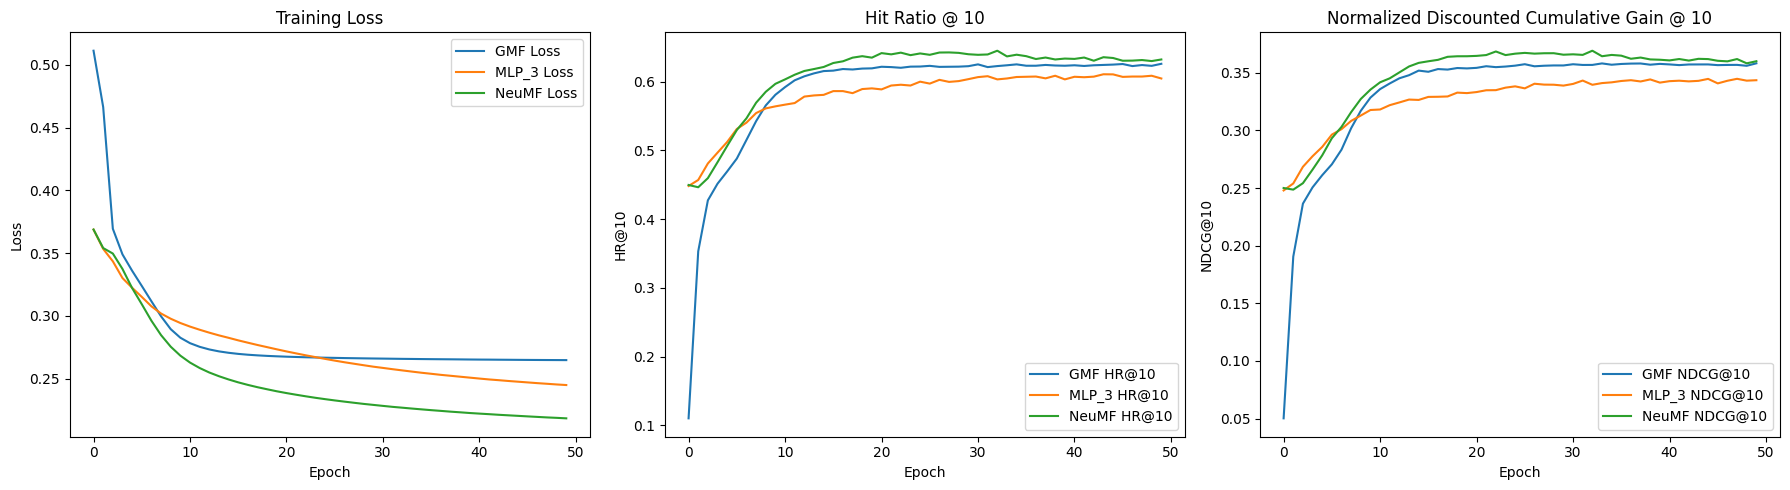

In [75]:
# compare the performance of different models

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(gmf_train_losses, label="GMF Loss")
plt.plot(mlp_3_train_losses, label="MLP_3 Loss")
plt.plot(neumf_train_losses, label="NeuMF Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(gmf_hrs, label="GMF HR@10")
plt.plot(mlp_3_hrs, label="MLP_3 HR@10")
plt.plot(neumf_hrs, label="NeuMF HR@10")
plt.xlabel("Epoch")
plt.ylabel("HR@10")
plt.title("Hit Ratio @ 10")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(gmf_ndcgs, label="GMF NDCG@10")
plt.plot(mlp_3_ndcgs, label="MLP_3 NDCG@10")
plt.plot(neumf_ndcgs, label="NeuMF NDCG@10")
plt.xlabel("Epoch")
plt.ylabel("NDCG@10")
plt.title("Normalized Discounted Cumulative Gain @ 10")
plt.legend()

plt.tight_layout()
plt.show()

In [72]:
# compare mlp with different layers

metric=["HR","NDCG"]
mlp_0_perf=[max(mlp_0_hrs),max(mlp_0_ndcgs)]
mlp_1_perf=[max(mlp_1_hrs),max(mlp_1_ndcgs)]
mlp_2_perf=[max(mlp_2_hrs),max(mlp_2_ndcgs)]
mlp_3_perf=[max(mlp_3_hrs),max(mlp_3_ndcgs)]
mlp_4_perf=[max(mlp_4_hrs),max(mlp_4_ndcgs)]

output_df=pd.DataFrame({"metric":metric,"mlp_0":mlp_0_perf,"mlp_1":mlp_1_perf,"mlp_2":mlp_2_perf,"mlp_3":mlp_3_perf,"mlp_4":mlp_4_perf})
output_df.head()

,metric,mlp_0,mlp_1,mlp_2,mlp_3,mlp_4
0,HR,0.452815,0.520530,0.577483,0.610762,0.624669
1,NDCG,0.251862,0.292952,0.327352,0.344839,0.353480
